# ICT4SM lab 3 - group 14

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv("Unipol_dataset_lab3.csv")

## Preliminary Analysis

In [19]:
df

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00
...,...,...,...,...,...,...,...
1415300,1415300,1000,474,2023-11-28 13:15:02,2023-11-28 13:36:51,U,0.52
1415301,1415301,1000,475,2023-11-28 14:49:22,2023-11-28 15:09:03,U,0.00
1415302,1415302,1000,476,2023-11-28 15:16:18,2023-11-28 15:18:11,U,0.00
1415303,1415303,1000,477,2023-11-28 15:18:31,2023-11-28 15:28:41,U,0.00


### Distribution of trip distance of different types of roads

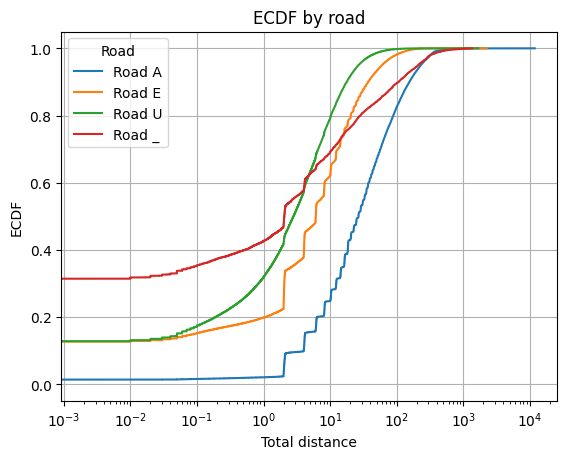

In [42]:
for road, group in df.groupby('road'):
    
    x = np.sort(group['total_distance'])
    y = np.arange(1, len(x) + 1) / len(x) # Calculate cumulated probabilities 
    
    plt.step(x, y, label=f'Road {road}')

plt.xscale('log')
plt.xlabel('Total distance')
plt.ylabel('ECDF')
plt.title('ECDF by road')
plt.legend(title='Road')
plt.grid()
plt.show()

- Road A : Highwaw
- Road E : Extra-Urban
- Road U : Urban

Highway trips rise slower than Urban or extraurban trips showing that user taking the highway tend to go further with their car, indicating longer trips, as could be expected with the use of highways. The fastest rise of Urban ECDF compared to Extra-Urban is also coherent with a use within a smaller zone (the city) with shorter distances.

### Distribution of trip duration

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\3483215745.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_durations = df.groupby('trip_id').apply(


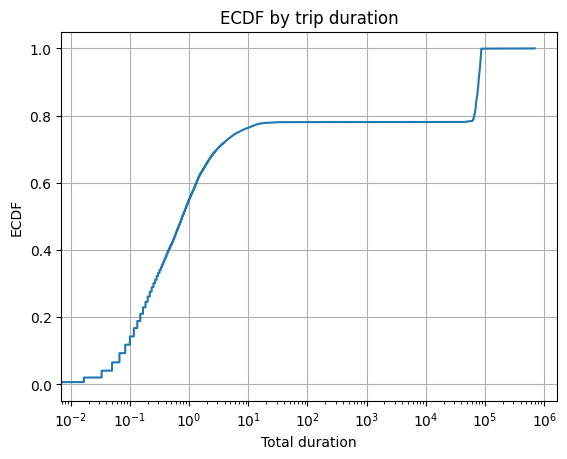

In [53]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

trip_durations = df.groupby('trip_id').apply(
    lambda group: (group['stop_time'].max() - group['start_time'].min()).total_seconds() / 60
).reset_index(name='durations')

x = np.sort(trip_durations['durations'])
y = np.arange(1, len(x) + 1) / len(x)

plt.plot(x,y)
plt.xscale('log')
plt.xlabel('Total duration')
plt.ylabel('ECDF')
plt.title('ECDF by trip duration')
plt.grid()
plt.show()

Some surprisingly high values, even though 80% are below 100s trip (around one and a half hour) we see some anormally long trips, up to 10**5 seconds which is a visible outlier. There also are some too short trips.

### Relationship between trip duration and distance

There is indeed a relationship between trip duration and distance : speed. Speed = distance/duration. For a same trip on different roads, we should see different speed. 

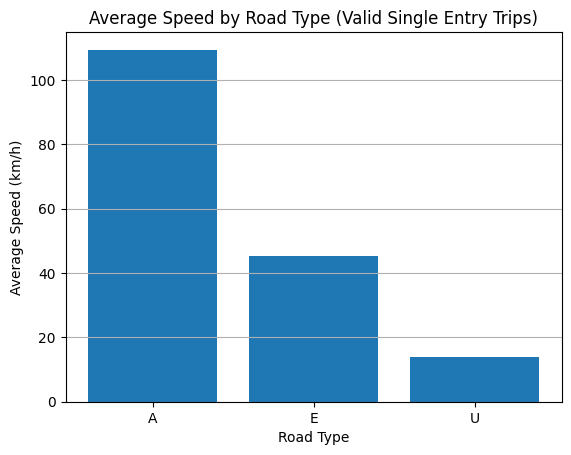

In [144]:
# Eliminate trips that have various roads
once_trips = df.groupby('trip_id').filter(lambda group: len(group) == 1)

once_trips['start_time'] = pd.to_datetime(once_trips['start_time'])
once_trips['stop_time'] = pd.to_datetime(once_trips['stop_time'])

once_trips['duration_hours'] = (once_trips['stop_time'] - once_trips['start_time']).dt.total_seconds() / 3600 # Duration of the trip

once_trips['speed_kmh'] = once_trips['total_distance'] / once_trips['duration_hours'] # Calculate the speed of the trip

valid_trips = once_trips[once_trips['duration_hours'] >= 0.02] # Eliminating too short trips (that give too high speed)

average_speed_by_road = valid_trips.groupby('road')['speed_kmh'].mean().reset_index() # Calculating the average speed


plt.bar(average_speed_by_road['road'], average_speed_by_road['speed_kmh'])

plt.xlabel('Road Type')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed by Road Type (Valid Single Entry Trips)')
plt.grid(axis='y')
plt.show()



We eliminated the too short trips (duration < 0.02 sec) because they gave too high speeds and incorrect representation and the trips that had been made on different roads, since the speed would change but we have only the global time of the trip. We therefore see that we indeed have a higher speed on highways than in extra urban that itself has greater speed than urban. The speed values are even relatively coherent with known speed in these roads, maybe a bit too fast on highway and too slow elsewhere.

### How many valid trips are recorded in the dataset?

We can delete trips that are : 
- Under 5 minutes and longer than 10 hours
- Require a speed more than one and a half over the average speed on their road (unfeasible trips)
- Have a total distance under 1 km
- Occured on an unknown road

In [150]:
def filter_data(df) :
    df=pd.read_csv("Unipol_dataset_lab3.csv")
    old = df.shape[0]
    print(f"Initial total number of trips: {old}")

    # Duration in hours and speed
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['stop_time'] = pd.to_datetime(df['stop_time'])
    df['duration_hours'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 3600
    df['speed'] = df['total_distance'] / df['duration_hours']

    road_speed = df.groupby('road')['speed'].mean().reset_index(name='average_speed') # Group by road and calculate the average speed

    df = pd.merge(df, road_speed, on='road', how='left') # Merge the average speed back into the original DataFrame

    df = df[df['speed'] <= 1.5 * df['average_speed']] # Trips with speed <= 1.5 * average road speed

    df = df[df['total_distance'] >= 1] # Trips with total distance >= 1 km

    df = df[df['road'].isin(['A', 'E', 'U'])] # Remove unknown roads

    new = df.shape[0]
    percentage = (new - old ) / old * 100
    # Debug: Check the final DataFrame
    print(f"Total number of valid trips: {new}")
    print(f"Percentage of decreasing: {percentage}")

    return df

df=pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df)


Initial total number of trips: 1415305
Total number of valid trips: 1048418
Percentage of decreasing: -25.922822289188552


# Tasks

## 1. Analysing behaviours of vehicles

### Compute the statistics and distribution of the values on workdays and weekends/holidays.

Initial total number of trips: 1415305
Total number of valid trips: 1048418
Percentage of decreasing: -25.922822289188552


C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\554951891.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


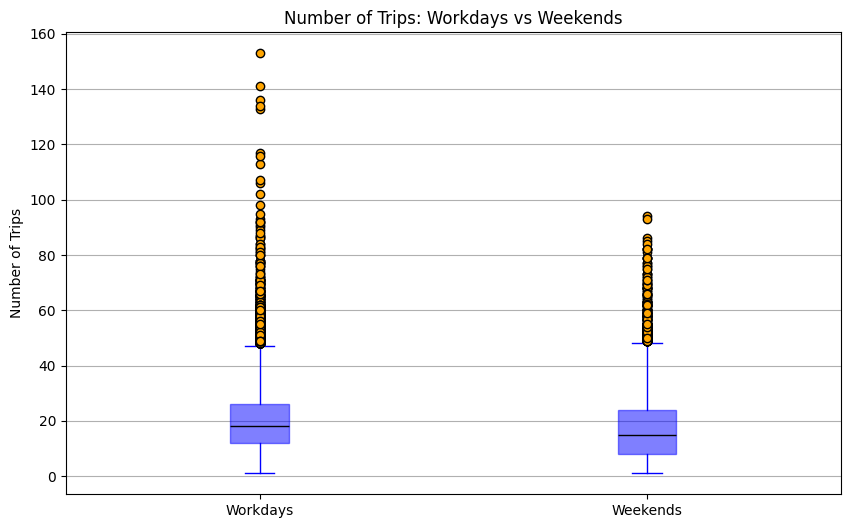

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\554951891.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


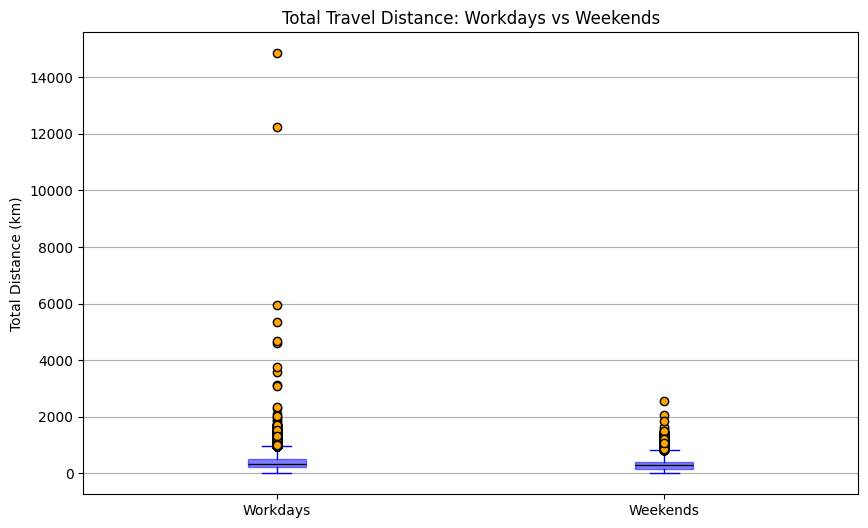

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\554951891.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


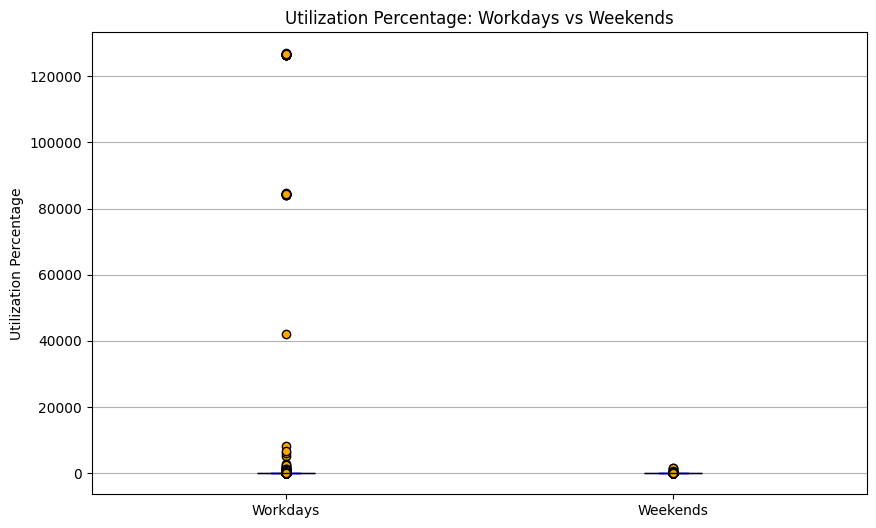

In [151]:
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df) 

# Convert start_time and stop_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])
df['day'] = df['start_time'].dt.date # Get the good date format to detect if it is a weekend or not later
df['driving_time_minutes'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 60

# Aggregate daily stats per vehicle
daily_stats = df.groupby(['vehicle_id', 'day']).agg(
    num_trips=('trip_id', 'count'),
    total_distance=('total_distance', 'sum'),
    total_driving_time=('driving_time_minutes', 'sum')
).reset_index()

daily_stats['utilization_percentage'] = (daily_stats['total_driving_time'] / (24 * 60)) * 100 # Calculate utilization percentage

# Classify workdays (0-4) and weekends (5-6)
daily_stats['day_of_week'] = pd.to_datetime(daily_stats['day']).dt.weekday
daily_stats['is_weekend'] = daily_stats['day_of_week'].isin([5, 6])

# Prepare data for boxplots
workday_trips = daily_stats[daily_stats['is_weekend'] == False]['num_trips']
weekend_trips = daily_stats[daily_stats['is_weekend'] == True]['num_trips']

workday_distance = daily_stats[daily_stats['is_weekend'] == False]['total_distance']
weekend_distance = daily_stats[daily_stats['is_weekend'] == True]['total_distance']

workday_utilization = daily_stats[daily_stats['is_weekend'] == False]['utilization_percentage']
weekend_utilization = daily_stats[daily_stats['is_weekend'] == True]['utilization_percentage']

# Function to plot a boxplot
def plot_boxplot(data, labels, title, ylabel, colors):
    plt.figure(figsize=(10, 6))
    plt.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        boxprops=dict(facecolor=colors[0], color=colors[0], alpha=0.5),
        medianprops=dict(color='black'),
        whiskerprops=dict(color=colors[0]),
        capprops=dict(color=colors[0]),
        flierprops=dict(marker='o', markerfacecolor=colors[1], markersize=6, linestyle='none')
    )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.show()

# Number of Trips
plot_boxplot(
    data=[workday_trips, weekend_trips],
    labels=['Workdays', 'Weekends'],
    title='Number of Trips: Workdays vs Weekends',
    ylabel='Number of Trips',
    colors=['blue', 'orange']
)

# Total Travel Distance
plot_boxplot(
    data=[workday_distance, weekend_distance],
    labels=['Workdays', 'Weekends'],
    title='Total Travel Distance: Workdays vs Weekends',
    ylabel='Total Distance (km)',
    colors=['blue', 'orange']
)

# Utilization Percentage
plot_boxplot(
    data=[workday_utilization, weekend_utilization],
    labels=['Workdays', 'Weekends'],
    title='Utilization Percentage: Workdays vs Weekends',
    ylabel='Utilization Percentage',
    colors=['blue', 'orange']
)


### 1.b : For each vehicle, compute the fraction of its trips with different road types

Initial total number of trips: 1415305
Total number of valid trips: 1048418
Percentage of decreasing: -25.922822289188552


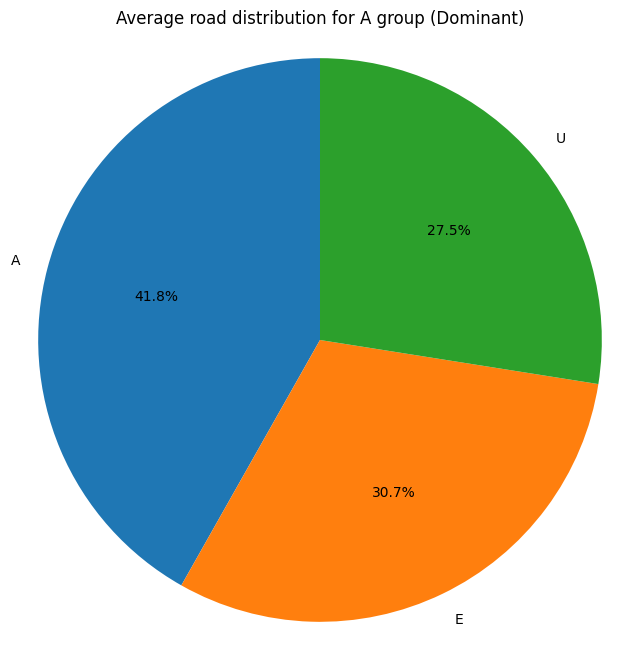

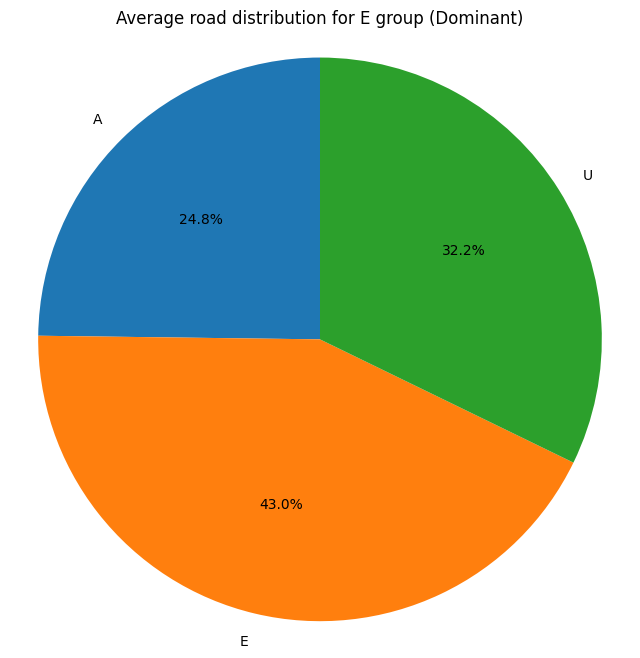

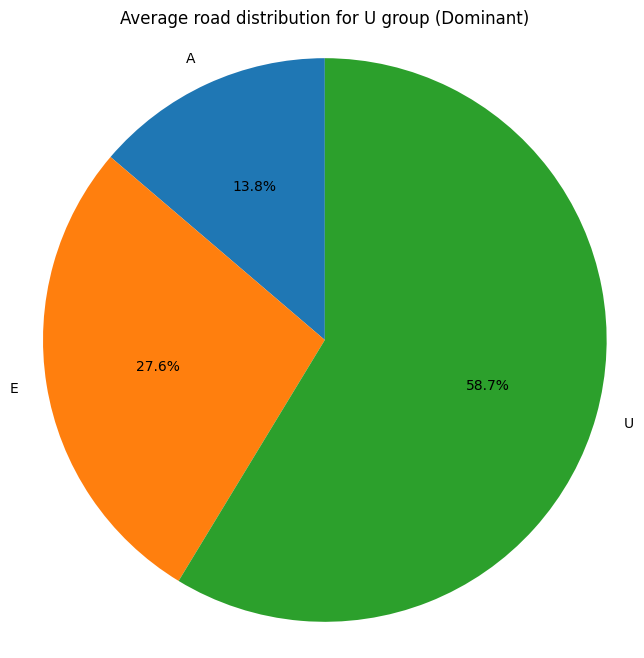

In [ ]:
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df)

# Calculate the number of trips by road for each vehicle and fraction
road_counts = df.groupby(['vehicle_id', 'road'])['trip_id'].count().reset_index(name='road_trip_count')
total_trips = road_counts.groupby('vehicle_id')['road_trip_count'].sum().reset_index(name='total_trips')

road_fractions = pd.merge(road_counts, total_trips, on='vehicle_id')
road_fractions['road_fraction'] = road_fractions['road_trip_count'] / road_fractions['total_trips']

# Pivot to get road fractions for each vehicle
road_fraction_pivot = road_fractions.pivot(index='vehicle_id', columns='road', values='road_fraction')

road_fraction_pivot['dominant_road'] = road_fraction_pivot.idxmax(axis=1)  # Identify dominant road by vehicle (most represented one)
dominant_groups = road_fraction_pivot.groupby('dominant_road') # Group vehicles by their dominant road
group_averages = dominant_groups.mean()  # Average fractions per road type for each group

for road, avg_fraction in group_averages.iterrows():
    plt.figure(figsize=(8, 8))
    labels = avg_fraction.index
    sizes = avg_fraction.values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Average road distribution for {road} group (Dominant)')
    plt.axis('equal')  

We chose here to represent the average fraction repartition of roads for cars separated in three groups, defined by the road that is the most represented, A for highway, E or U. We can see that in general, user stick for a very large part to the road they use most and do not show a very balances usage of roads, unless they use mainly highways. This shows that highway users tend to have an equilibrated mobility diagram and may moove mor throu different situations whereas extra urban and mostly urban users keep more the same usage.

## 2. Choose and define the evaluation metrics that you want to monitor

We chose the following three EV models to evaluate : 
- BMW i4 eDrive40 https://ev-database.org/car/1252/BMW-i4-eDrive40
- Skoda Elroq 85 https://ev-database.org/car/3033/Skoda-Elroq-85
- Kia Niro EV https://ev-database.org/car/1666/Kia-Niro-EV

The metrics that we are going to track will be : 
- Percentage of feasible trips
- Percentage of completedness of the trip
- Battery percentage at the end of the day

## 3. Implement the replicator of trips and simulator of EV

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\3805024110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data['start_time'] = pd.to_datetime(vehicle_data['start_time'])
C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\3805024110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data['stop_time'] = pd.to_datetime(vehicle_data['stop_time'])


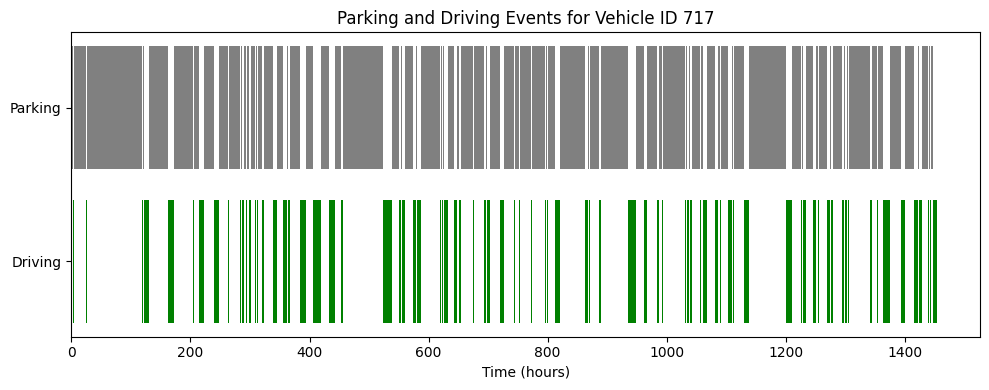

In [170]:
#df = pd.read_csv('Unipol_dataset_lab3.csv')


random_vehicle_id = df['vehicle_id'].sample(1).iloc[0] # Select a random vehicle just to run the simulation here and see
vehicle_data = df[df['vehicle_id'] == random_vehicle_id]

vehicle_data['start_time'] = pd.to_datetime(vehicle_data['start_time'])
vehicle_data['stop_time'] = pd.to_datetime(vehicle_data['stop_time'])

plt.figure(figsize=(10, 4))

# Driving and Parking visualization
for _, row in vehicle_data.iterrows():
    plt.barh('Driving', (row['stop_time'] - row['start_time']).total_seconds() / 3600, left=(row['start_time'] - vehicle_data['start_time'].min()).total_seconds() / 3600, color='green')

sorted_data = vehicle_data.sort_values('start_time')
for i in range(len(sorted_data) - 1):
    end_time = sorted_data.iloc[i]['stop_time']
    start_time_next = sorted_data.iloc[i + 1]['start_time']
    if start_time_next > end_time:
        plt.barh('Parking', (start_time_next - end_time).total_seconds() / 3600, left=(end_time - vehicle_data['start_time'].min()).total_seconds() / 3600, color='grey')

plt.xlabel('Time (hours)')
plt.title(f'Parking and Driving Events for Vehicle ID {random_vehicle_id}')
plt.tight_layout()
plt.show()